# 一维无粘Burgers方程数值实验

Burgers方程是流体力学中的典型非线性偏微分方程，其基本形式为：

$$ u_t + u u_x = \nu u_{xx} $$

其中，$u$ 是速度，$\nu$ 是粘性系数，$x$ 是空间坐标，$t$ 是时间。  
在一维无粘Burgers方程中，粘性系数为0，方程变为：

$$ u_t + u u_x = 0 $$

该方程具有解析解，但是在实际应用中，通常需要通过数值方法求解。

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# 守恒型方程有限差分方法求解流程

## 守恒型方程基本形式
守恒律方程的一般形式为：
$$
\frac{\partial u}{\partial t} + \frac{\partial F(u)}{\partial x} = 0
$$
其中：
- $u$ 为守恒量（如质量、动量、能量）
- $F(u)$ 为通量函数

## 有限差分方法求解步骤

### 1. 空间离散
- 将计算域划分为均匀网格：
  $$
  x_i = i\Delta x,\quad i = 0,1,...,N
  $$
- 定义网格中心值：
  $$
  u_i^n \approx u(x_i, t^n)
  $$

### 2. 通量重构
通过数值通量近似物理通量：
$$
F_{i+1/2} = F(u_i, u_{i+1})
$$
常用格式：
- **中心差分**：$F_{i+1/2} = \frac{1}{2}[F(u_i) + F(u_{i+1})]$
- **Lax-Friedrichs**：$F_{i+1/2} = \frac{1}{2}[F(u_i) + F(u_{i+1})] - \frac{\Delta x}{2\Delta t}(u_{i+1}-u_i)$
- **Lax-Wendroff**：二阶精度格式
- **迎风格式**：根据特征方向选择差分方向

### 3. 时间离散
采用时间积分方法（如显式Euler法）：
$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} + \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x} = 0
$$
整理得更新公式：
$$
u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}\left(F_{i+1/2} - F_{i-1/2}\right)
$$

### 4. 边界条件处理
常用方法：
- **周期边界**：$u_0 = u_N,\ u_{N+1} = u_1$
- **固定边界**：$u_0 = u_{left},\ u_N = u_{right}$
- **零梯度边界**：$u_0 = u_1,\ u_N = u_{N-1}$

### 5. 稳定性条件
需满足CFL条件：
$$
\Delta t \leq \frac{\Delta x}{\max|f'(u)|}
$$
其中$f'(u)$为通量函数的特征速度


## 时间格式

### 二、数值方法解析
#### 1. 时间离散方案（TimeScheme类）
- EulerForward ：显式欧拉法（条件稳定）
- RungeKutta ：四阶龙格库塔法（高精度、条件稳定）
- EulerBackward/CrankNicolson ：隐式/半隐式方法（未实际调用）
代码中主要使用 `RungeKutta` 方法进行时间推进

In [ ]:
class TimeScheme(object):
	def __init__(self, dt):
		self.dt = dt

	def EulerForward(self, u, rhs, i, j):
		return u[i][j] + self.dt * rhs(u[i], i, j)

	def EulerBackward(self, u, rhs, i, j):
		return u[i][j] + self.dt * rhs(u[i+1], i, j)

	def CrankNicolson(self, u, rhs, i, j):
		return u[i][j] + self.dt * rhs(0.5*(u[i]+u[i+1]), j)

	def RungeKutta(self, u, rhs, i, j):
		k1 = rhs(u[i], i, j)
		k2 = rhs(u[i] + 0.5*self.dt*k1, i, j)
		k3 = rhs(u[i] + 0.5*self.dt*k2, i, j)
		k4 = rhs(u[i] + self.dt*k3, i, j)
		return u[i][j] + self.dt*(k1 + 2*k2 + 2*k3 + k4)/6	
		


# 2. 空间离散方案（SpatialScheme类）
对对流项采用高阶格式：

- ENO ：本质无震荡格式（通过加权组合三个候选模板）
- WENO ：加权ENO格式（通过光滑度指标动态调整权重）
- Central ：中心差分格式（用于粘性项）
对粘性项采用 `Central5` 五阶中心差分格式：

In [ ]:
class SpatialScheme:
	def Central(self, u, i):
		return u[i+1] - u[i-1]
	def Central2(self, u, i):
		return u[i+1] - 2 * u[i] + u[i-1]
	def Central4(self, u, i):
		return 1/12 * u[i-2] - 2/3 * u[i-1] + 2/3 * u[i+1] - 1/12 * u[i+2]
	def Central5(self, u, i):
		return 1/12 * u[i-2] - 4/3 * u[i-1] + 5/2 * u[i] - 4/3 * u[i+1] + 1/12 * u[i+2]

	def Upwind(self, u, i):
		return u[i]
		
	def ENO1(self, u, i):
		return 11/6 * u[i] - 7/6 * u[i-1] + 1/3 * u[i-2]
	def ENO2(self, u, i):
		return -1/6 * u[i-1] + 5/6 * u[i] + 1/3 * u[i+1]
	def ENO3(self, u, i):
		return 1/3 * u[i] + 5/6 * u[i+1] - 1/6 * u[i+2]

	def ENO(self, u, i):
		return 1/10 * self.ENO1(u, i) + 3/5 * self.ENO2(u, i) + 3/10 * self.ENO3(u, i)
	
	def WENO(self, u, i):
		beta1 = 13/12 * (u[i-2] - 2*u[i-1] + u[i])**2 + 1/4 * (u[i-2] - 4*u[i-1] + 3*u[i])**2
		beta2 = 13/12 * (u[i-1] - 2*u[i] + u[i+1])**2 + 1/4 * (u[i-1] - u[i+1])**2
		beta3 = 13/12 * (u[i] - 2*u[i+1] + u[i+2])**2 + 1/4 * (-3*u[i] + 4*u[i+1] - u[i+2])**2
		
		epsilon = 1e-6
		alpha1 = 0.1 / (beta1 + epsilon)**2
		alpha2 = 0.6 / (beta2 + epsilon)**2
		alpha3 = 0.3 / (beta3 + epsilon)**2
		
		omega_sum = alpha1 + alpha2 + alpha3
		w1 = alpha1 / omega_sum
		w2 = alpha2 / omega_sum
		w3 = alpha3 / omega_sum
		return w1 * self.ENO1(u, i) + w2 * self.ENO2(u, i) + w3 * self.ENO3(u, i)
			


## 有限差分法Finite Difference Method

### 三、算法流程
1. 初始化场量（正弦波）
2. 时间层循环推进
3. 每个时间步内：
   - 更新边界条件
   - 使用选定的时间积分方案更新内部节点
   - 每100步可视化结果

In [ ]:
class FiniteDifference:
    def __init__(self, timescheme, spacescheme,nt, nx ,endntime, endnspace, vic):
        self.timescheme = timescheme
        self.spacescheme = spacescheme
        self.endntime = endntime
        self.endnspace = endnspace
        self.ntime = nt
        self.nspace = nx
        self.dt = endntime / nt
        self.dx = endnspace / nx
        print(f"CFL Number : {self.dt/self.dx}")
        self.vic = vic
        self.field = np.zeros((self.ntime, 3 * self.nspace))
        self.field[0] = self.initial_conditions()
        self.boundary_conditions(1)
        plt.figure(figsize=(10, 6)) 
        self.plot(0)
        

    def initial_conditions(self):
        a = np.sin(np.linspace(0, self.endnspace, self.nspace)) + 10
        return np.concatenate((a, a, a))

    def boundary_conditions(self, i):
        self.field[i, 0: self.nspace] = self.field[i-1, self.nspace: 2 * self.nspace]
        self.field[i, 2*self.nspace:] = self.field[i-1, self.nspace: 2 * self.nspace]

    def res(self, u, i):
        return (-u[i + 2] + 16 * u[i + 1] - 30 * u[i] + 16 * u[i - 1] - u[i - 2]) / (12 * self.dx**2)

    # def flux(self, u, i):
    #     f = 0.5 * u**2
    #     a = 0.5 * (u[i] + u[i+1]) 
    #     if (a >= 0):
    #         flux = self.spacescheme(f, i) 
    #     else:
    #         flux = self.spacescheme(f, i+1)
    #     return flux 

    def flux(self, u, i):
        ul, ur = self.spacescheme(u, i), self.spacescheme(u, i+1)
        fl, fr = 0.5 * ul**2, 0.5 * ur**2
        a = np.abs((fl-fr)/(ul-ur + 1e-8))
        return 0.5 * (fl + a * ul) + 0.5 * (fr - a * ur)

    def rhs(self, u, i, j):
        return -(self.flux(u, j) - self.flux(u, j-1)) / self.dx + self.vic * self.res(u, j)

    def solve(self):
        for i in range(1, self.ntime):
            self.boundary_conditions(i)
            for j in range(self.nspace, 2 * self.nspace):
                self.field[i][j] = self.timescheme(self.field, self.rhs, i-1, j)
            if (i % 5000 == 0 or i == self.ntime-1):
                self.plot(i)

    def plot(self, i):
        plt.plot(self.field[i, self.nspace: 2*self.nspace], label=f'Time step: {i}')
        plt.grid(True)  # Add grid for better visualization
        plt.title(f'Time step: {i}')
        plt.xlabel('Space')
        plt.ylabel('Value')
        plt.legend()
        

    def run(self):
        self.solve()
        plt.show()
        plt.matshow(self.field[: :500 , self.nspace: 2*self.nspace], cmap='viridis')
        plt.xlabel('Space')
        plt.ylabel('Time')
        plt.colorbar()
        plt.show()




# 显式方法

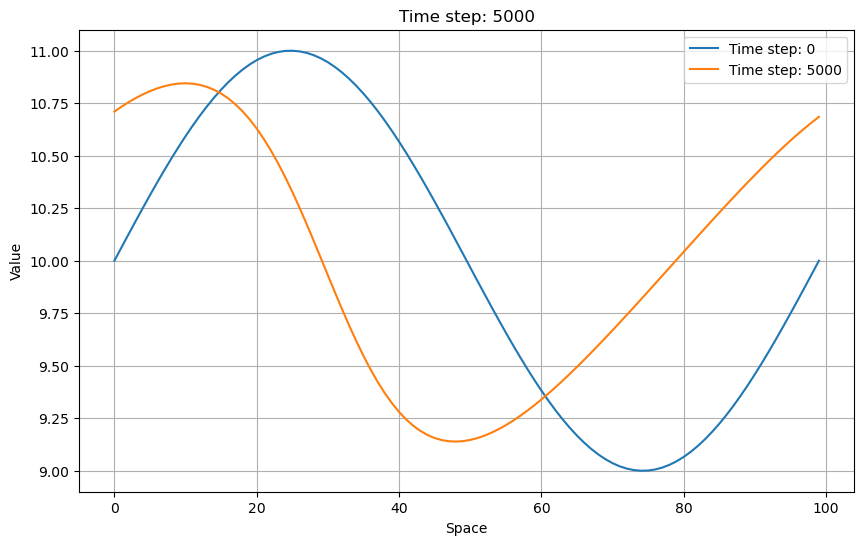

In [5]:
endtime = 2.0 
endspace = 2*np.pi
Nt = 20000
Nx = 100
Tsc = TimeScheme(endtime/Nt)
Ssc = SpatialScheme()
exp1 = FiniteDifference(Tsc.RungeKutta, Ssc.Upwind, Nt, Nx, endtime, endspace, 0.00)
exp1.run()

In [ ]:
exp2 = FiniteDifference(Tsc.RungeKutta, Ssc.ENO, Nt, Nx, endtime, endspace, 0.00)
exp2.run()

In [ ]:
exp3 = FiniteDifference(Tsc.RungeKutta, Ssc.WENO, Nt, Nx, endtime, endspace, 0.00)
exp3.run()